In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from scipy.ndimage import median_filter
import sys
import os

from windrose import WindroseAxes
import cmcrameri as cmc
from cmcrameri import cm
from scipy.stats import linregress
from scipy.signal import welch, csd
from datetime import datetime
from scipy.optimize import curve_fit
import pickle



sys.path.append(os.path.join(os.getcwd(), 'EC'))
sys.path.append(os.path.join(os.getcwd(), 'plotting'))
sys.path.append(os.path.join(os.getcwd(), 'MO'))
sys.path.append(os.path.join(os.getcwd(), 'SPC'))

import Func_read_data
import Func_despike_data
import sensor_info
import Func_DR
import Func_MRFD
import Funcs_plots
import normalize
import Func_MO

importlib.reload(Func_read_data)
importlib.reload(Func_despike_data)
importlib.reload(sensor_info)
importlib.reload(Func_DR)
importlib.reload(Func_MRFD)
importlib.reload(Funcs_plots)
importlib.reload(normalize)
importlib.reload(Func_MO)

from Func_read_data import *
from Func_despike_data import *
from sensor_info import *
from Func_MRFD import *
from Func_DR import *
from Funcs_plots import *
from normalize import *
from Func_MO import *

In [3]:
cryos_path = '/run/user/72637/gvfs/smb-share:domain=INTRANET,server=samba.hpc.epfl.ch,share=cryos,user=engbers/'
folder_SFC=cryos_path+'CRYOS/Projects/Antarctica/PrincessElisabeth/Season_2024-2025/DATA/processed/SFC_DR/'
folder_16m=cryos_path+'CRYOS/Projects/Antarctica/PrincessElisabeth/Season_2024-2025/DATA/processed/CSAT_16m_DR/'
folder_26m=cryos_path+'CRYOS/Projects/Antarctica/PrincessElisabeth/Season_2024-2025/DATA/processed/CSAT_26m_DR/'

In [33]:
fs=10
def compute_coherence(u1, u2, dz, label, color=None):
    u1_clean, u2_clean = u1.align(u2, join='inner')
    mask = (~u1_clean.isna()) & (~u2_clean.isna())
    u1_clean = u1_clean[mask]
    u2_clean = u2_clean[mask]

    f, S11 = welch(u1_clean, fs=fs, nperseg= 4096)
    _, S22 = welch(u2_clean, fs=fs, nperseg= 4096)
    _, S12 = csd(u1_clean, u2_clean, fs=fs, nperseg= 4096)
    coh = np.abs(S12)**2 / (S11 * S22)

    u_mean = ((u1_clean + u2_clean) / 2).mean()
    def model(f, a):
        return np.exp(-a * dz * f / u_mean)

    mask_fit = np.isfinite(coh) & np.isfinite(f)
    popt, _ = curve_fit(model, f[mask_fit], coh[mask_fit], p0=[1.0])
    a_best = popt[0]
    y = model(f, a_best)

    return f, coh, y, a_best
def plot_coherence(u1, u2, dz, label, color=None):
    u1_clean, u2_clean = u1.align(u2, join='inner')
    mask = (~u1_clean.isna()) & (~u2_clean.isna())
    u1_clean = u1_clean[mask]
    u2_clean = u2_clean[mask]

    f, S11 = welch(u1_clean, fs=fs, nperseg= 4096)
    _, S22 = welch(u2_clean, fs=fs, nperseg= 4096)
    _, S12 = csd(u1_clean, u2_clean, fs=fs, nperseg= 4096)
    coh = np.abs(S12)**2 / (S11 * S22)

    u_mean = ((u1_clean + u2_clean) / 2).mean()
    def model(f, a):
        return np.exp(-a * dz * f / u_mean)

    mask_fit = np.isfinite(coh) & np.isfinite(f)
    popt, _ = curve_fit(model, f[mask_fit], coh[mask_fit], p0=[1.0])
    a_best = popt[0]
    y = model(f, a_best)

    # Convert frequency to period in seconds, avoid division by zero
    period = np.where(f > 0, 1 / f, np.nan)
    plt.semilogx(period, coh, label=fr'{label} $|\mathrm{{S}}_{{ij}}|^2/(\mathrm{{S}}_i \mathrm{{S}}_j)$', color=color)
    plt.semilogx(period, y, '--', label=f'{label} Fit: a={a_best:.2f}', color=color)
    plt.gca().invert_xaxis()

In [32]:

def load_fastdata(folder, start, end):
    start_dt = datetime.strptime(start, '%Y-%m-%d_%H:%M:%S')
    end_dt = datetime.strptime(end, '%Y-%m-%d_%H:%M:%S')
    all_dfs = []
    for root, dirs, files in os.walk(folder):
        files = sorted(files)
        for file in files:
            if file.endswith('.dat'):
                try:
                    date_str = file.split('_')[-2] + '_' + file.split('_')[-1].split('.')[0]
                    file_dt = datetime.strptime(date_str, '%Y-%m-%d_%H%M')
                    if start_dt <= file_dt <= end_dt:
                        file_path = os.path.join(root, file)
                        # print(f"Processing file: {file_path}")
                        df = pd.read_csv(file_path, index_col=0, parse_dates=True, sep='\t')
                        df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
                        all_dfs.append(df)
                except Exception:
                    pass
    if all_dfs:
        return pd.concat(all_dfs)
    else:
        return pd.DataFrame()


In [90]:
wd1_45_90_periods

[(Timestamp('2024-01-30 16:18:00'), Timestamp('2024-02-01 02:44:00')),
 (Timestamp('2024-02-17 05:35:00'), Timestamp('2024-02-17 20:30:00')),
 (Timestamp('2024-02-17 23:34:00'), Timestamp('2024-02-19 01:16:00')),
 (Timestamp('2024-02-27 17:51:00'), Timestamp('2024-02-28 09:41:00')),
 (Timestamp('2024-03-16 08:03:00'), Timestamp('2024-03-17 00:18:00')),
 (Timestamp('2024-05-08 03:29:00'), Timestamp('2024-05-08 18:12:00')),
 (Timestamp('2024-06-14 03:19:00'), Timestamp('2024-06-14 16:31:00')),
 (Timestamp('2024-07-04 23:41:00'), Timestamp('2024-07-06 22:22:00')),
 (Timestamp('2024-07-17 07:59:00'), Timestamp('2024-07-18 17:39:00')),
 (Timestamp('2024-07-20 05:40:00'), Timestamp('2024-07-20 20:47:00')),
 (Timestamp('2024-07-25 15:02:00'), Timestamp('2024-07-26 14:33:00')),
 (Timestamp('2024-07-26 14:34:00'), Timestamp('2024-07-27 05:55:00')),
 (Timestamp('2024-07-28 13:12:00'), Timestamp('2024-07-30 22:52:00')),
 (Timestamp('2024-08-06 08:01:00'), Timestamp('2024-08-07 20:33:00')),
 (Time

In [ ]:
start='2024-08-17_00:00:00'
end='2024-08-18_06:00:00'
import pickle

# Load the list from the file
with open('wd1_45_90_periods.pkl', 'rb') as f:
    wd1_45_90_periods = pickle.load(f)
with open('wd1_90_180_periods.pkl', 'rb') as f:
    wd1_90_180_periods = pickle.load(f)
# Load the list from the file
with open('stability_0_02_periods.pkl', 'rb') as f:
    stability_0_02_periods= pickle.load(f)
with open('stability_02_10_periods.pkl', 'rb') as f:
    stability_02_10_periods = pickle.load(f)



fastdata_SFC_periods = []
fastdata_16_periods = []
fastdata_26_periods = []

for period_start, period_end in stability_0_02_periods[0:15]:
    # fastdata_SFC_periods = []
    # fastdata_16_periods = []
    # fastdata_26_periods = []
    start_str = period_start.strftime('%Y-%m-%d_%H:%M:%S')
    end_str = period_end.strftime('%Y-%m-%d_%H:%M:%S')
    print(f"Processing period: {start_str} to {end_str}")
    
    # Load and append data for each period
    sfc_df = load_fastdata(folder_SFC, start_str, end_str)
    fastdata_SFC_periods.append(sfc_df)
    df_16 = load_fastdata(folder_16m, start_str, end_str)
    fastdata_16_periods.append(df_16)
    df_26 = load_fastdata(folder_26m, start_str, end_str)
    fastdata_26_periods.append(df_26)

# After the loop, concatenate all periods into one continuous DataFrame for each height
fastdata_SFC_all = pd.concat(fastdata_SFC_periods, axis=0)
fastdata_16_all = pd.concat(fastdata_16_periods, axis=0)
fastdata_26_all = pd.concat(fastdata_26_periods, axis=0)
plt.figure(figsize=(10, 5))

# Check if data is empty before plotting
try:
    u1 = fastdata_SFC_periods[0]['Ux']
    u2 = fastdata_16_periods[0]['Ux']
    u3 = fastdata_26_periods[0]['Ux']
    if u1.empty or u2.empty or u3.empty:
        print("One or more dataframes are empty, skipping this period.")
        continue
    plot_coherence(u1, u2, dz=14, label='SFC-16m', color='tab:blue')
    plot_coherence(u1, u3, dz=24, label='SFC-26m', color='tab:orange')
    plot_coherence(u2, u3, dz=10, label='16m-26m', color='tab:green')
    plt.xlabel('Frequency [s]')
    plt.ylabel('Coherence')
    plt.title(f'Vertical Coherence of Streamwise Velocity z/L 0.2-10 {period_start}-{period_end}')
    # plt.legend()
    # plt.savefig(f'./plots_coherence/coherence_plot_zl0.2_10_{start_str}_{end_str}.png', dpi=300)
    # plt.show()
except Exception as e:
    print(f"Error during plotting for period {start_str} to {end_str}: {e}")
    continue
plt.show()

Processing period: 2024-01-30_10:00:00 to 2024-01-31_09:00:00
Processing period: 2024-01-31_14:00:00 to 2024-02-01_08:00:00
Processing period: 2024-02-06_10:00:00 to 2024-02-07_12:00:00
Processing period: 2024-02-07_13:30:00 to 2024-02-08_09:30:00
Processing period: 2024-02-08_20:30:00 to 2024-02-10_03:00:00
Processing period: 2024-02-17_00:00:00 to 2024-02-19_07:30:00
Processing period: 2024-02-23_04:30:00 to 2024-02-24_01:00:00
Processing period: 2024-02-24_03:30:00 to 2024-02-24_15:30:00
Processing period: 2024-02-24_16:00:00 to 2024-02-26_04:00:00
Processing period: 2024-02-26_04:30:00 to 2024-02-26_18:30:00
Processing period: 2024-02-26_23:30:00 to 2024-02-28_19:30:00
Processing period: 2024-03-02_03:00:00 to 2024-03-03_16:30:00
Processing period: 2024-03-10_06:00:00 to 2024-03-10_21:00:00
Processing period: 2024-03-15_13:30:00 to 2024-03-16_05:00:00
Processing period: 2024-03-16_13:30:00 to 2024-03-17_08:30:00


SyntaxError: 'continue' not properly in loop (3450797439.py, line 51)

<Figure size 1000x500 with 0 Axes>

/tmp/ipykernel_746158/1122742076.py:23: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


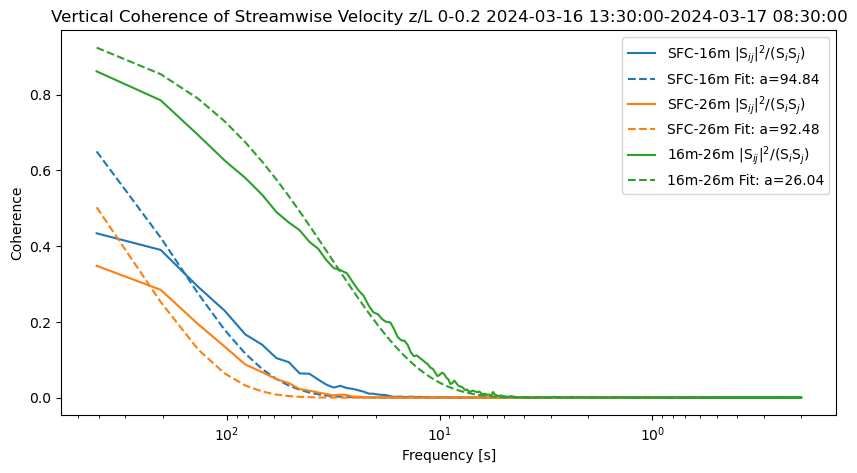

In [21]:
plt.figure(figsize=(10, 5))

# Check if data is empty before plotting
u1 = fastdata_SFC_all['Ux']
u2 = fastdata_16_all['Ux']
u3 = fastdata_26_all['Ux']
if u1.empty or u2.empty or u3.empty:
    print("One or more dataframes are empty, skipping this period.")
plot_coherence(u1, u2, dz=14, label='SFC-16m', color='tab:blue')
plot_coherence(u1, u3, dz=24, label='SFC-26m', color='tab:orange')
plot_coherence(u2, u3, dz=10, label='16m-26m', color='tab:green')
plt.xlabel('Frequency [s]')
plt.ylabel('Coherence')
plt.title(f'Vertical Coherence of Streamwise Velocity z/L 0-0.2 {period_start}-{period_end}')
plt.legend()
plt.savefig(f'./plots_coherence/coherence_plot_zl0_0.2_{start_str}_{end_str}.png', dpi=300)
# plt.show()

/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: div

Error during event 2024-07-20_05:40:00 to 2024-07-20_20:47:00: `ydata` must not be empty!


/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


Error during event 2024-08-06_08:01:00 to 2024-08-07_20:33:00: `ydata` must not be empty!


/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


Error during event 2024-08-23_18:46:00 to 2024-08-24_19:32:00: `ydata` must not be empty!
Error during event 2024-08-26_06:08:00 to 2024-08-26_20:20:00: `ydata` must not be empty!
Error during event 2024-08-27_20:52:00 to 2024-08-28_15:15:00: `ydata` must not be empty!


/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:38: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: div

Skipping event 2024-12-01_01:01:00 to 2024-12-02_09:24:00 due to empty data.
Skipping event 2024-12-02_09:25:00 to 2024-12-02_23:05:00 due to empty data.
Skipping event 2024-12-03_06:37:00 to 2024-12-03_23:25:00 due to empty data.
Skipping event 2024-12-04_02:23:00 to 2024-12-04_17:41:00 due to empty data.
Skipping event 2024-12-08_05:20:00 to 2024-12-08_18:20:00 due to empty data.


/tmp/ipykernel_746158/513399625.py:84: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:84: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:84: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:84: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: div

Error during event 2024-08-31_00:40:00 to 2024-08-31_13:40:00: `ydata` must not be empty!


/tmp/ipykernel_746158/513399625.py:84: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:84: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:84: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/513399625.py:84: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)
/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: div

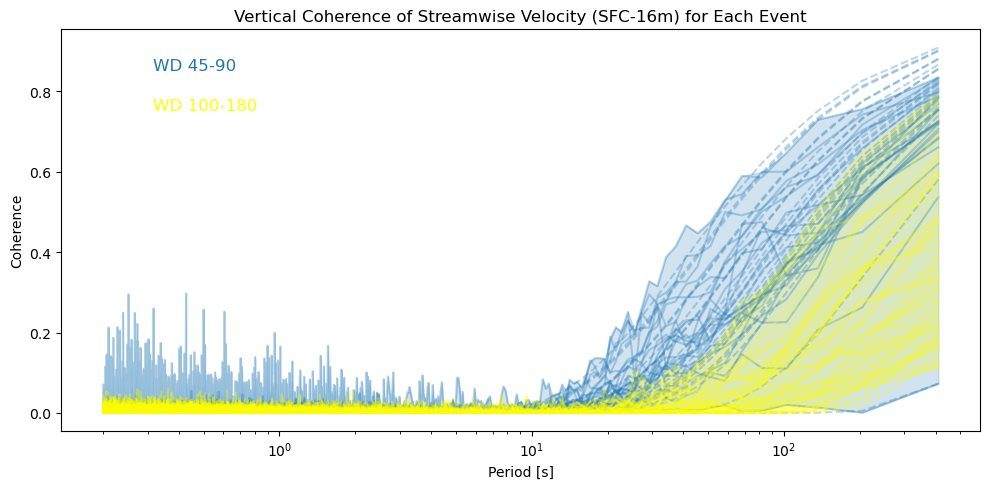

In [ ]:
with open('wd1_45_90_periods.pkl', 'rb') as f:
    wd1_45_90_periods = pickle.load(f)
with open('wd1_90_180_periods.pkl', 'rb') as f:
    wd1_90_180_periods = pickle.load(f)
# Load the list from the file
with open('stability_0_02_periods.pkl', 'rb') as f:
    stability_0_02_periods= pickle.load(f)
with open('stability_02_10_periods.pkl', 'rb') as f:
    stability_02_10_periods = pickle.load(f)

plt.figure(figsize=(10, 5))

# Store all coherence curves for each event
all_coh = []
all_period = []

for period_start, period_end in wd1_45_90_periods:
    start_str = period_start.strftime('%Y-%m-%d_%H:%M:%S')
    end_str = period_end.strftime('%Y-%m-%d_%H:%M:%S')
    sfc_df = load_fastdata(folder_SFC, start_str, end_str)
    df_16 = load_fastdata(folder_16m, start_str, end_str)
    # Align and check for empty data
    if sfc_df.empty or df_16.empty:
        print(f"Skipping event {start_str} to {end_str} due to empty data.")
        continue
    u1, u2 = sfc_df['Ux'], df_16['Ux']
    try:
        # Align and clean
        u1_clean, u2_clean = u1.align(u2, join='inner')
        mask = (~u1_clean.isna()) & (~u2_clean.isna())
        u1_clean = u1_clean[mask]
        u2_clean = u2_clean[mask]
        # Use plot_coherence to compute and plot
        f, S11 = welch(u1_clean, fs=fs, nperseg=4096)
        _, S22 = welch(u2_clean, fs=fs, nperseg=4096)
        _, S12 = csd(u1_clean, u2_clean, fs=fs, nperseg=4096)
        coh = np.abs(S12)**2 / (S11 * S22)
        period = np.where(f > 0, 1 / f, np.nan)
        all_coh.append(coh)
        all_period.append(period)
        plot_coherence(u1_clean, u2_clean, dz=14, label=f'{start_str}-{end_str}', color='tab:blue')
        plt.gca().get_lines()[-2].set_alpha(0.3)  # Set the main curve alpha
        plt.gca().get_lines()[-1].set_alpha(0.3)  # Set the fit curve alpha
    except Exception as e:
        print(f"Error during event {start_str} to {end_str}: {e}")
        continue

# Filter out empty arrays before min/max calculation
all_coh_filtered = [c for c in all_coh if c.size > 0]
all_period_filtered = [p for p in all_period if p.size > 0]
all_coh = np.array(all_coh_filtered)
all_period = np.array(all_period_filtered)
if len(all_coh) > 0:
    # Use the first period array as x-axis (they should all be the same)
    period_ref = all_period[0]
    coh_min = np.nanmin(all_coh, axis=0)
    coh_max = np.nanmax(all_coh, axis=0)
    plt.fill_between(period_ref, coh_min, coh_max, color='tab:blue', alpha=0.2, label='Min/Max envelope')
all_coh=[]
all_period=[]
# Repeat for the second set of periods

for period_start, period_end in wd1_90_180_periods:
    start_str = period_start.strftime('%Y-%m-%d_%H:%M:%S')
    end_str = period_end.strftime('%Y-%m-%d_%H:%M:%S')
    sfc_df = load_fastdata(folder_SFC, start_str, end_str)
    df_16 = load_fastdata(folder_16m, start_str, end_str)
    # Align and check for empty data
    if sfc_df.empty or df_16.empty:
        print(f"Skipping event {start_str} to {end_str} due to empty data.")
        continue
    u1, u2 = sfc_df['Ux'], df_16['Ux']
    try:
        # Align and clean
        u1_clean, u2_clean = u1.align(u2, join='inner')
        mask = (~u1_clean.isna()) & (~u2_clean.isna())
        u1_clean = u1_clean[mask]
        u2_clean = u2_clean[mask]
        # Use plot_coherence to compute and plot
        f, S11 = welch(u1_clean, fs=fs, nperseg=4096)
        _, S22 = welch(u2_clean, fs=fs, nperseg=4096)
        _, S12 = csd(u1_clean, u2_clean, fs=fs, nperseg=4096)
        coh = np.abs(S12)**2 / (S11 * S22)
        period = np.where(f > 0, 1 / f, np.nan)
        all_coh.append(coh)
        all_period.append(period)
        plot_coherence(u1_clean, u2_clean, dz=14, label=f'{start_str}-{end_str}', color='yellow')
        plt.gca().get_lines()[-2].set_alpha(0.3)  # Set the main curve alpha
        plt.gca().get_lines()[-1].set_alpha(0.3)  # Set the fit curve alpha
    except Exception as e:
        print(f"Error during event {start_str} to {end_str}: {e}")
        continue

all_coh_filtered = [c for c in all_coh if c.size > 0]
all_period_filtered = [p for p in all_period if p.size > 0]
all_coh = np.array(all_coh_filtered)
all_period = np.array(all_period_filtered)
if len(all_coh) > 0:
    # Use the first period array as x-axis (they should all be the same)
    period_ref = all_period[0]
    coh_min = np.nanmin(all_coh, axis=0)
    coh_max = np.nanmax(all_coh, axis=0)
    plt.fill_between(period_ref, coh_min, coh_max, color='yellow', alpha=0.2, label='Min/Max envelope')
plt.text(0.1, 0.9, 'WD 45-90', transform=plt.gca().transAxes, fontsize=12, color='tab:blue')
plt.text(0.1, 0.8, 'WD 100-180', transform=plt.gca().transAxes, fontsize=12, color='yellow')
plt.xlabel('Period [s]')
plt.ylabel('Coherence')
plt.title('Vertical Coherence of Streamwise Velocity (SFC-16m) for Each Event')
# plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig('./plots_coherence/14_wd45_180.png', dpi=300)
plt.show()


In [41]:
wd1_90_180_periods

[(Timestamp('2024-01-18 20:05:00'), Timestamp('2024-01-19 08:38:00')),
 (Timestamp('2024-02-28 20:00:00'), Timestamp('2024-02-29 09:20:00')),
 (Timestamp('2024-03-03 18:16:00'), Timestamp('2024-03-04 10:35:00')),
 (Timestamp('2024-03-09 01:39:00'), Timestamp('2024-03-09 21:25:00')),
 (Timestamp('2024-03-17 16:26:00'), Timestamp('2024-03-18 10:30:00')),
 (Timestamp('2024-04-02 22:52:00'), Timestamp('2024-04-03 19:04:00')),
 (Timestamp('2024-04-16 16:04:00'), Timestamp('2024-04-17 12:08:00')),
 (Timestamp('2024-04-18 06:28:00'), Timestamp('2024-04-18 20:32:00')),
 (Timestamp('2024-04-18 22:41:00'), Timestamp('2024-04-20 10:41:00')),
 (Timestamp('2024-05-03 06:27:00'), Timestamp('2024-05-03 22:01:00')),
 (Timestamp('2024-05-09 05:33:00'), Timestamp('2024-05-09 17:48:00')),
 (Timestamp('2024-05-19 10:53:00'), Timestamp('2024-05-20 10:21:00')),
 (Timestamp('2024-05-25 08:42:00'), Timestamp('2024-05-26 17:28:00')),
 (Timestamp('2024-05-31 21:04:00'), Timestamp('2024-06-02 06:27:00')),
 (Time

Processing period: 2024-09-19_08:30:00 to 2024-09-20_18:30:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


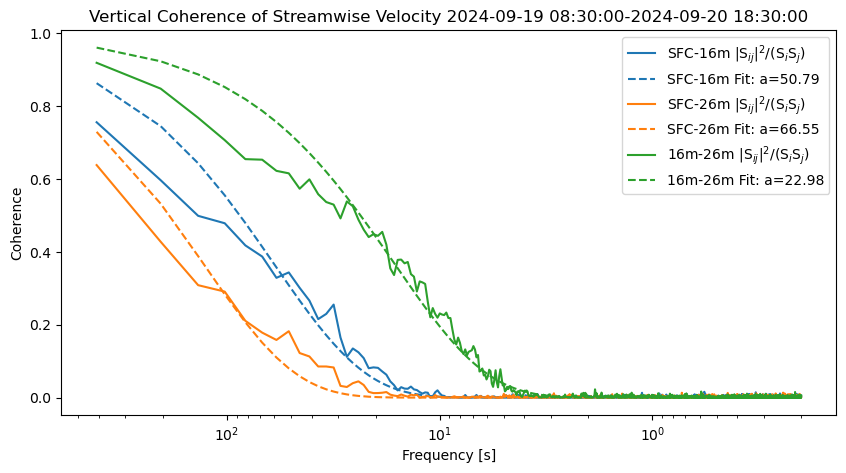

Processing period: 2024-10-16_02:30:00 to 2024-10-17_04:30:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


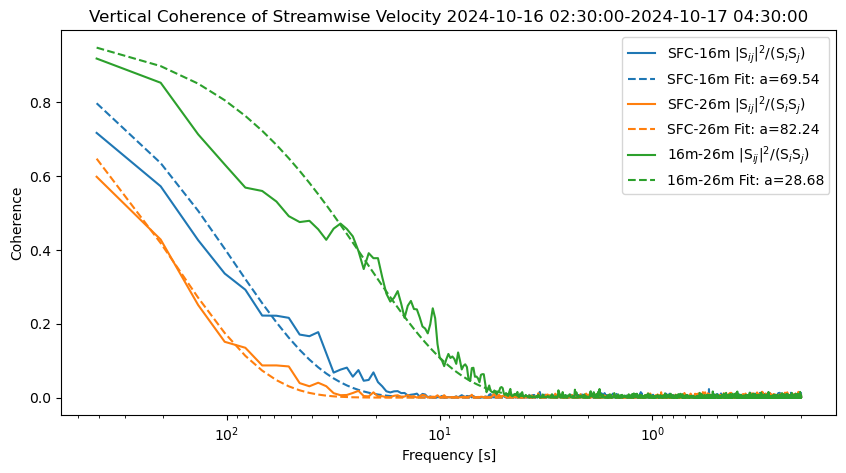

Processing period: 2024-10-28_16:00:00 to 2024-10-29_22:00:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


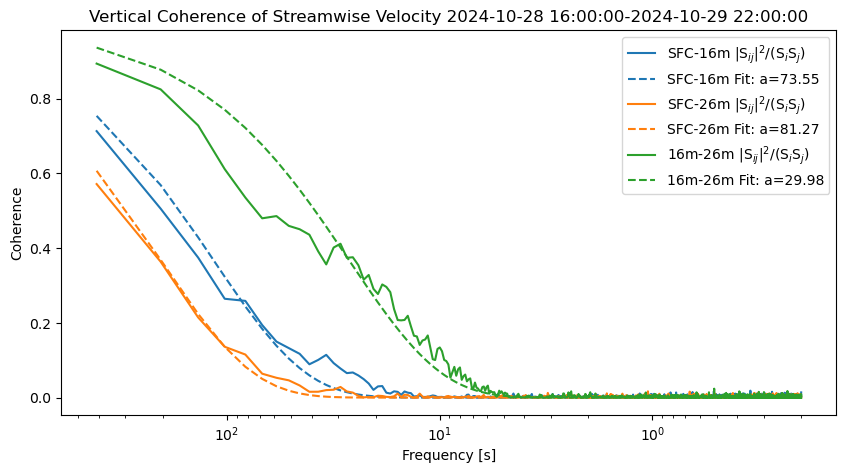

Processing period: 2024-04-18_19:00:00 to 2024-04-21_11:00:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


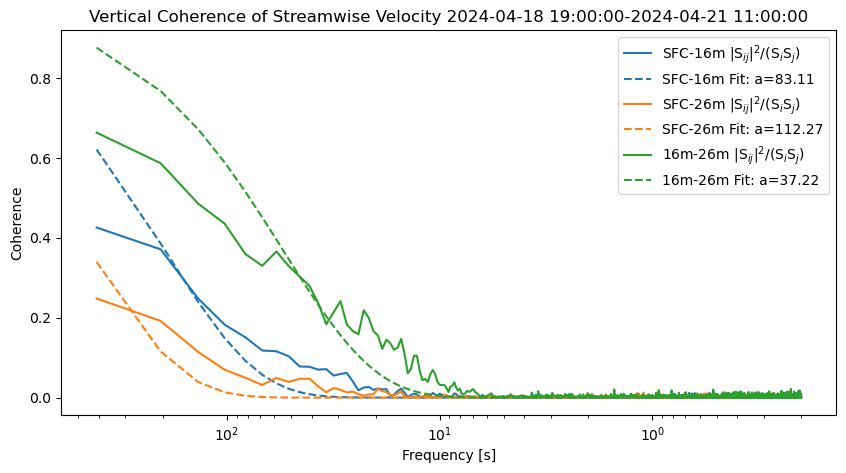

Processing period: 2024-06-08_22:00:00 to 2024-06-09_23:30:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


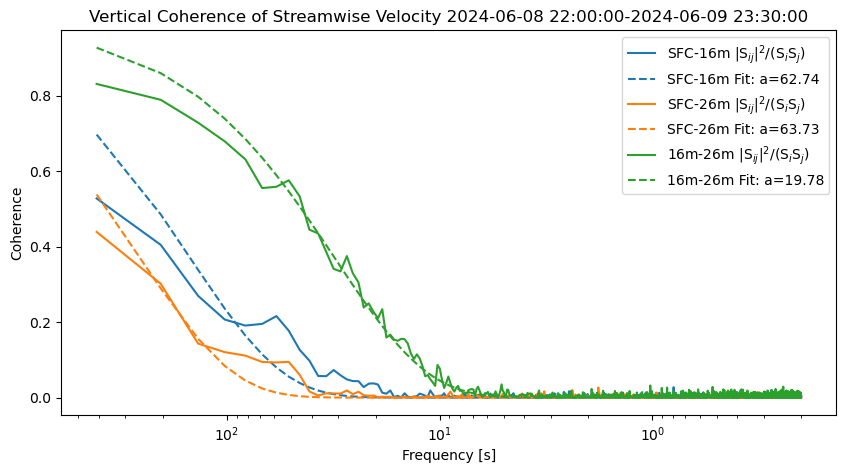

Processing period: 2024-11-06_13:30:00 to 2024-11-07_21:00:00


/tmp/ipykernel_746158/2192919350.py:44: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


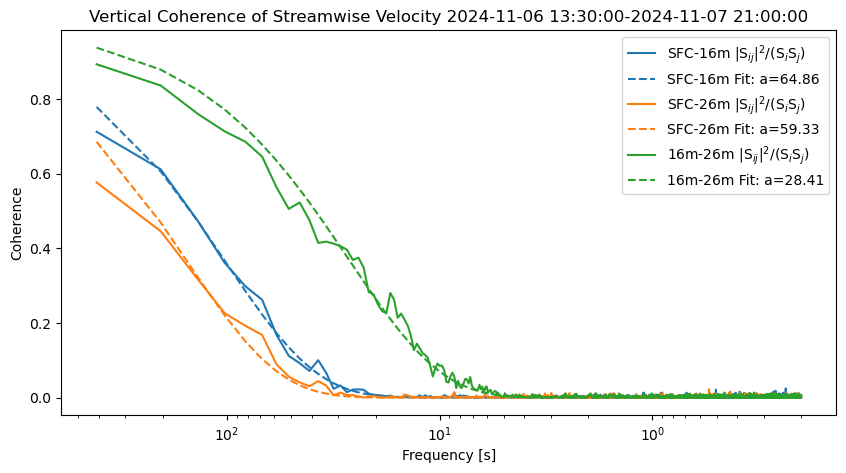

In [ ]:
with open('events.pkl', 'rb') as f:
    events = pickle.load(f)
    
for period_start, period_end in events:
    fastdata_SFC_periods = []
    fastdata_16_periods = []
    fastdata_26_periods = []
    start_str = period_start.strftime('%Y-%m-%d_%H:%M:%S')
    end_str = period_end.strftime('%Y-%m-%d_%H:%M:%S')
    print(f"Processing period: {start_str} to {end_str}")
    
    # Load and append data for each period
    sfc_df = load_fastdata(folder_SFC, start_str, end_str)
    fastdata_SFC_periods.append(sfc_df)
    df_16 = load_fastdata(folder_16m, start_str, end_str)
    fastdata_16_periods.append(df_16)
    df_26 = load_fastdata(folder_26m, start_str, end_str)
    fastdata_26_periods.append(df_26)

    # After the loop, concatenate all periods into one continuous DataFrame for each height
    fastdata_SFC_all = pd.concat(fastdata_SFC_periods, axis=0)
    fastdata_16_all = pd.concat(fastdata_16_periods, axis=0)
    fastdata_26_all = pd.concat(fastdata_26_periods, axis=0)
    plt.figure(figsize=(10, 5))

    # Check if data is empty before plotting
    try:
        u1 = fastdata_SFC_periods[0]['Ux']
        u2 = fastdata_16_periods[0]['Ux']
        u3 = fastdata_26_periods[0]['Ux']
        if u1.empty or u2.empty or u3.empty:
            print("One or more dataframes are empty, skipping this period.")
            continue
        plot_coherence(u1, u2, dz=14, label='SFC-16m', color='tab:blue')
        plot_coherence(u1, u3, dz=24, label='SFC-26m', color='tab:orange')
        plot_coherence(u2, u3, dz=10, label='16m-26m', color='tab:green')
        plt.xlabel('Frequency [s]')
        plt.ylabel('Coherence')
        plt.title(f'Vertical Coherence of Streamwise Velocity {period_start}-{period_end}')
        plt.legend()
        plt.savefig(f'./plots_specific_events/coherence_plot_zl0.2_10_{start_str}_{end_str}.png', dpi=300)
        plt.show()
    except Exception as e:
        print(f"Error during plotting for period {start_str} to {end_str}: {e}")
        continue
    plt.show()

/tmp/ipykernel_746158/1122742076.py:23: RuntimeWarning: divide by zero encountered in divide
  period = np.where(f > 0, 1 / f, np.nan)


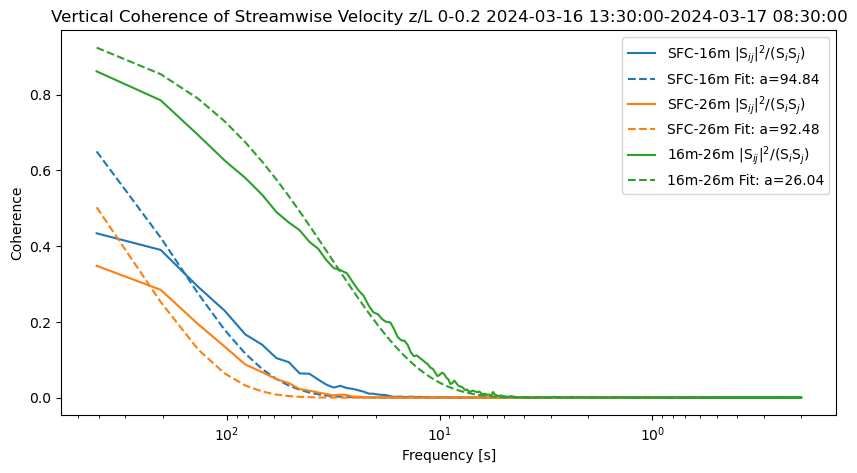

In [19]:
fs=10
def plot_coherence(u1, u2, dz, label, color=None):
    u1_clean, u2_clean = u1.align(u2, join='inner')
    mask = (~u1_clean.isna()) & (~u2_clean.isna())
    u1_clean = u1_clean[mask]
    u2_clean = u2_clean[mask]

    f, S11 = welch(u1_clean, fs=fs, nperseg= 4096)
    _, S22 = welch(u2_clean, fs=fs, nperseg= 4096)
    _, S12 = csd(u1_clean, u2_clean, fs=fs, nperseg= 4096)
    coh = np.abs(S12)**2 / (S11 * S22)

    u_mean = ((u1_clean + u2_clean) / 2).mean()
    def model(f, a):
        return np.exp(-a * dz * f / u_mean)

    mask_fit = np.isfinite(coh) & np.isfinite(f)
    popt, _ = curve_fit(model, f[mask_fit], coh[mask_fit], p0=[1.0])
    a_best = popt[0]
    y = model(f, a_best)

    # Convert frequency to period in seconds, avoid division by zero
    period = np.where(f > 0, 1 / f, np.nan)
    plt.semilogx(period, coh, label=fr'{label} $|\mathrm{{S}}_{{ij}}|^2/(\mathrm{{S}}_i \mathrm{{S}}_j)$', color=color)
    plt.semilogx(period, y, '--', label=f'{label} Fit: a={a_best:.2f}', color=color)
    plt.gca().invert_xaxis()


plt.figure(figsize=(10, 5))
plot_coherence(fastdata_SFC['Ux'], fastdata_16['Ux'], dz=14, label='SFC-16m', color='tab:blue')
plot_coherence(fastdata_SFC['Ux'], fastdata_26['Ux'], dz=24, label='SFC-26m', color='tab:orange')
plot_coherence(fastdata_16['Ux'], fastdata_26['Ux'], dz=10, label='16m-26m', color='tab:green')
plt.xlabel('Frequency [s]')
plt.ylabel('Coherence')
plt.title('Vertical Coherence of Streamwise Velocity')
plt.legend()
plt.show()


NameError: name 'fastdata_SFC' is not defined

<Figure size 1000x500 with 0 Axes>

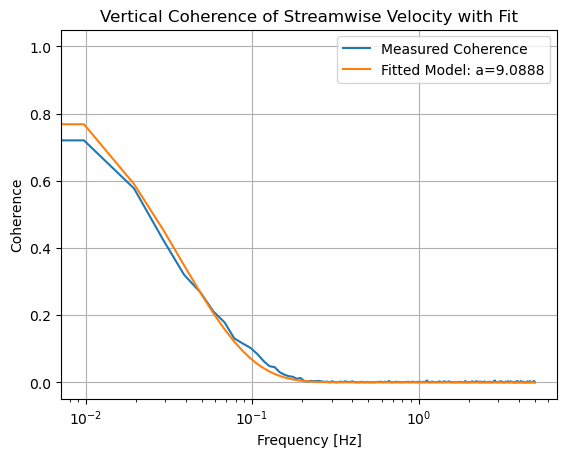

In [ ]:

dz=14
u_mean= ((fastdata_SFC['Ux']+ fastdata_16['Ux'])/2).mean()
def model(f, a):
    return np.exp(-a * dz * f / u_mean)

# Use only the valid (finite) values for curve fitting
mask_fit = np.isfinite(coh) & np.isfinite(f)
popt, pcov = curve_fit(model, f, coh, p0=[1.0])
a_best = popt[0]
y = model(f, a_best)
plt.semilogx(f, coh, label='Measured Coherence')
plt.semilogx(f, y,label=f'Fitted Model: a={a_best:.4f}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.title('Vertical Coherence of Streamwise Velocity with Fit')
plt.legend()
plt.grid(True)

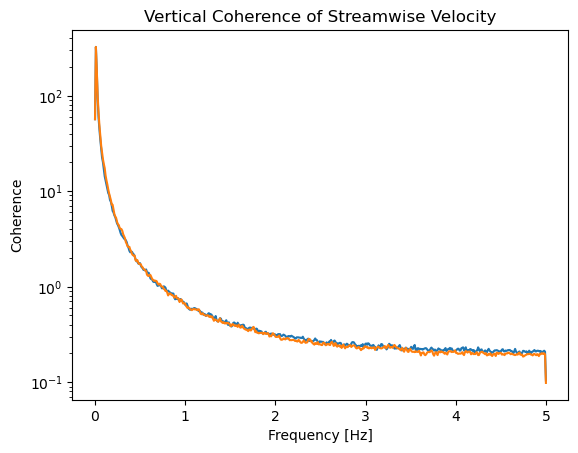

In [58]:
plt.semilogy(f, S11/w_var1**2, label='S11')
plt.semilogy(f, S22/w_var1**2, label='S22')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.title('Vertical Coherence of Streamwise Velocity')
plt.show()

In [42]:
S11

array([2.24954496e+00, 1.20950342e+01, 6.42328721e+00, 3.13105660e+00,
       1.84653092e+00, 1.34552167e+00, 1.02783138e+00, 8.71014155e-01,
       6.85780014e-01, 5.47096997e-01, 4.83529131e-01, 4.12359742e-01,
       3.62814776e-01, 3.37258435e-01, 3.07019727e-01, 2.84473319e-01,
       2.50768083e-01, 2.29083949e-01, 2.07634717e-01, 1.96851847e-01,
       1.89549471e-01, 1.78748558e-01, 1.65252601e-01, 1.59477403e-01,
       1.45566018e-01, 1.36377441e-01, 1.30411085e-01, 1.30538845e-01,
       1.17705096e-01, 1.15198198e-01, 1.11057819e-01, 1.06720494e-01,
       1.02175140e-01, 1.00108881e-01, 9.17210869e-02, 8.69321404e-02,
       8.77704060e-02, 8.68530348e-02, 8.54466799e-02, 8.25054630e-02,
       7.43553921e-02, 7.32084531e-02, 7.11362048e-02, 7.08447917e-02,
       6.78968359e-02, 6.51200322e-02, 6.25764889e-02, 6.05913501e-02,
       6.08828338e-02, 5.86433108e-02, 5.82667743e-02, 5.59419626e-02,
       5.48830757e-02, 5.50766366e-02, 5.45002811e-02, 5.22412592e-02,
      

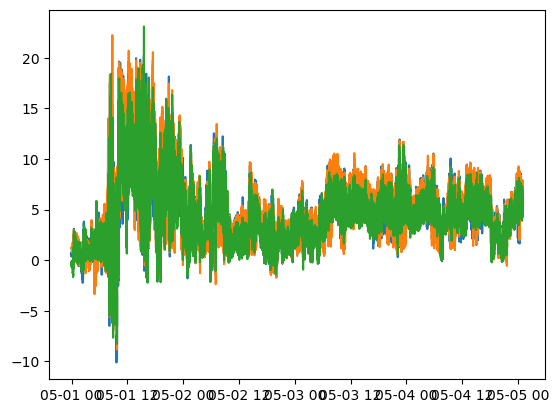

In [53]:
plt.plot(u1)
plt.plot(u2)
plt.plot(fastdata_SFC['Ux'])
